### Gambling system - Martingale
In this notebook we will test the potential of using a generic Martingale scheme for consistently making profit on Roulette gambling. The aim of the notebook is to use a system that is as generic as possible, with as many hyper parameters as feasible and optimize for the profit.  
  
The idea goes as following: Rather than playing one game with potentially large losses, we play multiple smaller games with a fixed initial investment *S*. If that investment is lost, we don't fall into the sunk cost fallacy and continue to invest, but we initialize a new game with the same initial investment.  
The first bet in the game is always a fixed percentage of the initial investment, *pS*. On every gamble that we lose, we increase the next bet times a pre-defined function, *f(m)*, where *m* is the number of bets lost. For the begining, this will be a constant function, e.g. *f(m)=1.90*.
The objective of one simulation in which we play *N* games is to compute the total profit (or loss) with a statistically significant margin.
References:  
[1] https://towardsdatascience.com/the-truth-about-the-martingale-betting-system-499c30467af1  
[2] 

### Hyper Parameters:
N - number of games in a simulation  
n - number of gables in a game  
wp - wining percentage in each round (18/37 = 48.64%)  
S - initial investment per game  
p - fractio of the first bet relative to the invested sum  
f(m) - multiplier of the bet after each lost round

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# initialize hyperparameters
N = 100
n = 10
p = 0.01
wp = 18/37
S = 10
f = lambda x: 1.90

In [3]:
def run_game(n,p,f,wp=18/37):
    lost_rounds = 0 # initialize counter
    profit = 0 # initialize the profit
    for i in range(n):
        # start by placing the current bet
        current_bet = p * f(lost_rounds) ** (lost_rounds)
        # if by placing the bet we go over threshold, then end the game with the current losses
        if (profit-current_bet < -1):
            return profit
        #else continue the game
        else:
            profit = profit - current_bet

        # now run the bet
        if (np.random.rand() < wp):
            # won: profit in this round is equal to twice the current bet placed
            profit = profit + 2 * current_bet
            # re-initialize number of lost rounds in a row
            lost_rounds = 0
        else:
            lost_rounds = lost_rounds + 1
            
    return profit

In [4]:
def run_simulation(n,p,f,N=100,SEED=88):
    np.random.seed(SEED)
    profit_list = []
    for i in range(N):
        profit_list.append(run_game(n,p,f))
    return np.array(profit_list)

In [5]:
n = 10
l = run_simulation(10,0.01,lambda x: 2.0,N = 10000,SEED=None)
print('Expected profit after playing {} hands per game is {} +/- {}'.format(n,round(l.mean(),3),round(l.std(),3)))

Expected profit after playing 10 hands per game is -0.008 +/- 0.158


In [6]:
n = np.arange(1, 50, 1)  
p = np.arange(0.005, 0.5, 0.005)  
xa, xb = np.meshgrid(n, p)
z = []
for n_ in n:
    for p_ in p:
        z.append(run_simulation(n_,p_,lambda x: 1.8, N=100, SEED=None).mean())
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z

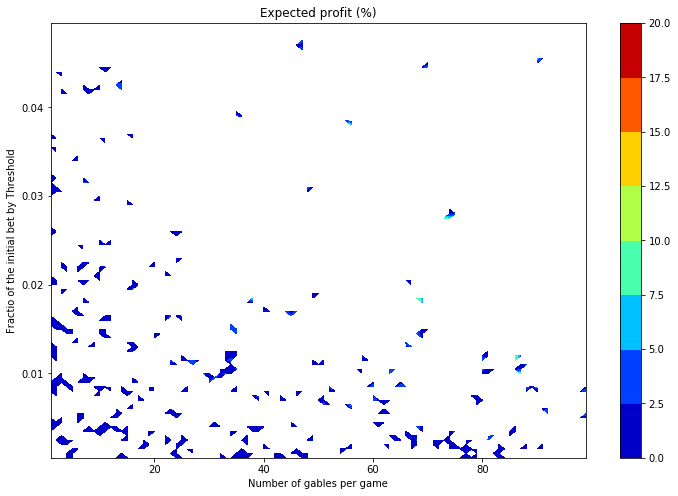

In [34]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Expected profit (%)')
plt.savefig('gambling_game.png')
plt.show()
print('the total gains: {}'.format(z.sum().sum()))

Ok, it seems like we've reached a ceiling. It seems to be generally true that lower fractio of initial investments yield better results. We are yet to draw any conclusion about the influence of the number of gables per game.  
Let's try to see what happens for p << 0.1

In [22]:
n = np.arange(1, 100, 1)  
p = np.arange(0.0005, 0.05, 0.0005)  
xa, xb = np.meshgrid(n, p)
z = []
for n_ in n:
    for p_ in p:
        z.append(run_simulation(n_,p_,lambda x: 1.8, N=100, SEED=None).mean())
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z

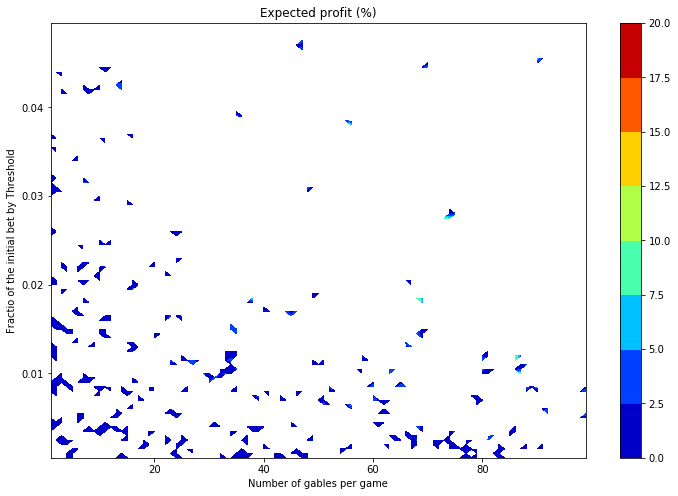

In [33]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')  
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Expected profit (%)')
plt.savefig('gambling_game_zoomed_smallp.png')
plt.show()
print('the total gains: {}'.format(z.sum().sum()))

The above plot still yields a larger percentage of losses than gains. The latest try will be with a ridicoulosly small percentage of initial investment. In theory, we expect that as we lower *p* we are replicating the ideal conditions for Martingale to work - infinite amount of capital. Let's see 'how easy' can we reach infinity:

In [37]:
n = np.arange(1, 100, 1)  
p = np.arange(5e-10, 5e-8, 5e-10)  
xa, xb = np.meshgrid(n, p)
z = []
for n_ in n:
    for p_ in p:
        z.append(run_simulation(n_,p_,lambda x: 1.8, N=100, SEED=None).mean())
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z

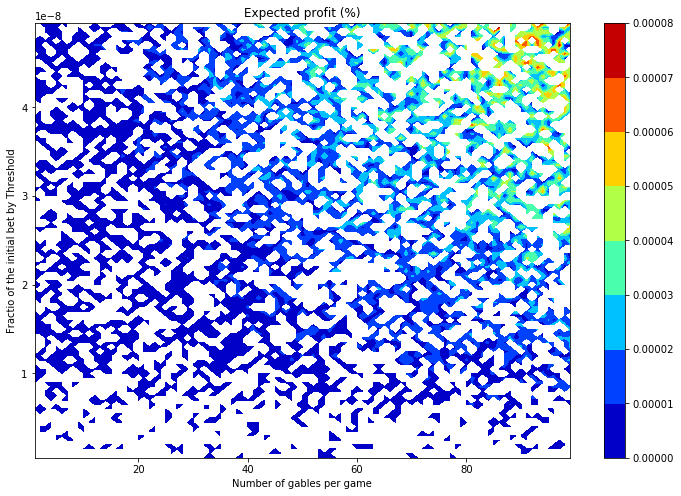

In [38]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')  
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Expected profit (%)')
plt.savefig('gambling_game_zoomed_smallestp.png')
plt.show()
print('the total gains: {}'.format(z.sum().sum()))

Ok, this plot looks more interesting than the previous ones. In this case it is not ovious whether there are more cases when we would have lost than when we would have gained. The bad news is that, besides the curious larger yields on the top right, the patterns still seems to look similar to a random noise. Let's check the total earnings from this area.

In [41]:
print('the total gains: {}'.format(z.sum().sum()))
print('total gains excluding lower part of plot: {}'.format(z[p>1e-8].sum().sum()))

the total gains: -0.21093946666707603
total gains excluding lower part of plot: -0.2079952770455383


### Concerned
By this point I am concerned that my initial function to play the roulette game might have a bug in it, since I expect to see a positive outcome from betting tiny portions of the amount I can afford to lose. Let's try to replicate the 'infinite' cash conditions required to satisfy martingale constraints in my initial function.

In [51]:
# updates: never exit game early
def run_game_infinite_cash(n,p,f,wp=18/37):
    lost_rounds = 0 # initialize counter
    profit = 0 # initialize the profit
    current_profit = []
    for i in range(n):
        current_profit.append(profit)
        # start by placing the current bet
        current_bet = p * f(lost_rounds) ** (lost_rounds)
        # if by placing the bet we go over threshold, then end the game with the current losses
        profit = profit - current_bet
        # now run the bet
        if (np.random.rand() < wp):
            # won: profit in this round is equal to twice the current bet placed
            profit = profit + 2 * current_bet
            # re-initialize number of lost rounds in a row
            lost_rounds = 0
        else:
            lost_rounds = lost_rounds + 1
        
    return np.array(current_profit)

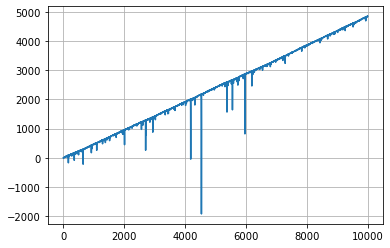

In [63]:
# now run the simulation for large n. Fix f(x) = 2
profit_by_n = run_game_infinite_cash(n=10000,p=1,f=lambda x:2.0)
plt.plot(profit_by_n)
plt.grid()

### Conclusions
1. There does not seem to be any free lunch around the martingale system as a betting strategy for roulette. The house will continue to win you over.
2. There is no escape from the issue of diverging betting value for the typical number of gambles that a person can take in a game (up to 100). If you capital is bellow billions for a roulette with minimun bet in cents, then you will effectively run out of money even if you would be allowed to bet any sum
3. There is a slight possibily that you can optimize the function 
4. Testing your assumptions through simulations can save you a fortune. Use it wisely. If you need help with any of your data science / engineering project, give be a shout at: https://www.linkedin.com/in/vlad-marius-griguta/